In [1]:
# imports
from dotenv import load_dotenv
import os

import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

import openai
from openai.embeddings_utils import cosine_similarity, get_embedding
from sklearn.metrics import PrecisionRecallDisplay

In [2]:
# parameters
EMBEDDING_MODEL = "text-embedding-ada-002"

# set OpenAI API key
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [3]:
# load data
datafile_path = "../data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to array
df

,Id,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
0,284932,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.007079250644892454, -0.027231059968471527, ..."
1,220697,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,35,"[-0.023640209808945656, -0.011873619630932808,..."
2,107908,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....",267,"[0.0002428288134979084, 0.005278090480715036, ..."
3,107800,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,239,"[0.010502707213163376, -0.013550193049013615, ..."
4,205313,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,86,"[0.015294435434043407, -0.003849664004519582, ..."
...,...,...,...,...,...,...,...,...,...
995,7178,B004OQLIHK,AKHQMSUORSA91,5,Delicious!,I have ordered these raisins multiple times. ...,Title: Delicious!; Content: I have ordered the...,43,"[-0.008800246752798557, -0.018662363290786743,..."
996,401972,B0006349W6,A21BT40VZCCYT4,5,Good Training Treat,My dog will come in from outside when I am tra...,Title: Good Training Treat; Content: My dog wi...,48,"[-0.024472814053297043, -0.0175948329269886, 0..."
997,462088,B00611F084,A6D4ND3C3BCYV,5,Jamica Me Crazy Coffee,Wolfgang Puck's Jamaica Me Crazy is that wonde...,Title: Jamica Me Crazy Coffee; Content: Wolfga...,40,"[-0.01685294136404991, -0.0051534585654735565,..."
998,267549,B005QKH5HA,A3LR9HCV3D96I3,5,Party Peanuts,Great product for the price. Mix with the Asia...,Title: Party Peanuts; Content: Great product f...,45,"[-0.010731690563261509, -0.01646377146244049, ..."


In [4]:
# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})
df

/var/folders/76/r353dd3n1cb9npy26cwjvyz00000gn/T/ipykernel_1732/41652990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})


,Id,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,sentiment
0,284932,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.007079250644892454, -0.027231059968471527, ...",positive
1,220697,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,35,"[-0.023640209808945656, -0.011873619630932808,...",negative
2,107908,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....",267,"[0.0002428288134979084, 0.005278090480715036, ...",positive
4,205313,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,86,"[0.015294435434043407, -0.003849664004519582, ...",positive
5,284450,B008PSM0BQ,A3OUFIMGL2K6RS,4,Good Sauce,This is a good all purpose sauce. Has good fl...,Title: Good Sauce; Content: This is a good all...,107,"[-0.016163131222128868, 0.005952909123152494, ...",positive
...,...,...,...,...,...,...,...,...,...,...
995,7178,B004OQLIHK,AKHQMSUORSA91,5,Delicious!,I have ordered these raisins multiple times. ...,Title: Delicious!; Content: I have ordered the...,43,"[-0.008800246752798557, -0.018662363290786743,...",positive
996,401972,B0006349W6,A21BT40VZCCYT4,5,Good Training Treat,My dog will come in from outside when I am tra...,Title: Good Training Treat; Content: My dog wi...,48,"[-0.024472814053297043, -0.0175948329269886, 0...",positive
997,462088,B00611F084,A6D4ND3C3BCYV,5,Jamica Me Crazy Coffee,Wolfgang Puck's Jamaica Me Crazy is that wonde...,Title: Jamica Me Crazy Coffee; Content: Wolfga...,40,"[-0.01685294136404991, -0.0051534585654735565,...",positive
998,267549,B005QKH5HA,A3LR9HCV3D96I3,5,Party Peanuts,Great product for the price. Mix with the Asia...,Title: Party Peanuts; Content: Great product f...,45,"[-0.010731690563261509, -0.01646377146244049, ...",positive


In [13]:
def evaluate_embeddings_approach(
        labels = ['negative', 'positive'],
        model = EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, engine=model) for label in labels] # get embeddings for labels

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0]) # positive - negative

    probas = df["embedding"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

              precision    recall  f1-score   support

    negative       0.61      0.88      0.72       136
    positive       0.98      0.90      0.94       789

    accuracy                           0.90       925
   macro avg       0.80      0.89      0.83       925
weighted avg       0.92      0.90      0.91       925



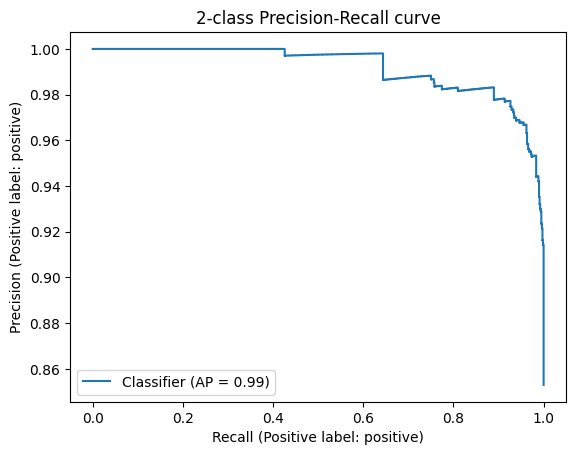

In [14]:
evaluate_embeddings_approach(labels=['negative', 'positive'], model=EMBEDDING_MODEL)

              precision    recall  f1-score   support

    negative       0.98      0.73      0.84       136
    positive       0.96      1.00      0.98       789

    accuracy                           0.96       925
   macro avg       0.97      0.86      0.91       925
weighted avg       0.96      0.96      0.96       925



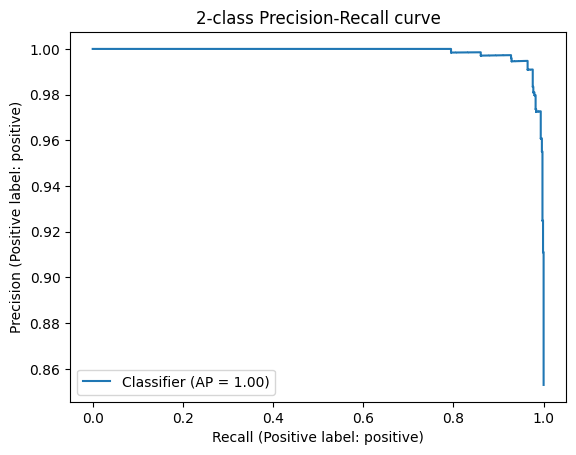

In [15]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])